In [1]:
#Assignment #4, part 1
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import csv
import datetime
import urllib
import zipfile
import scipy.stats 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#borrowed this code, download and unzip
def getunzipped(theurl, thedir):
  name = os.path.join(thedir, 'temp.zip')
  try:
    name, hdrs = urllib.urlretrieve(theurl, name)
  except IOError, e:
    print "Can't retrieve %r to %r: %s" % (theurl, thedir, e)
    return
  try:
    z = zipfile.ZipFile(name)
  except zipfile.error, e:
    print "Bad zipfile (from %r): %s" % (theurl, e)
    return
  for n in z.namelist():
    dest = os.path.join(thedir, n)
    destdir = os.path.dirname(dest)
    if not os.path.isdir(destdir):
      os.makedirs(destdir)
    data = z.read(n)
    f = open(dest, 'w')
    f.write(data)
    f.close()
  z.close()
  os.unlink(name)
    
    

In [3]:
if os.path.isfile('2014-08 - Citi Bike trip data.csv') is False:
    getunzipped('https://s3.amazonaws.com/tripdata/201408-citibike-tripdata.zip',os.getcwd())
citi_df = pd.read_csv('2014-08 - Citi Bike trip data.csv')

In [4]:
citi_df = citi_df[citi_df['birth year'] != '\N']
citi_df = citi_df[citi_df['gender'] != 0]

In [5]:
#create age variable--use 2014. This data set is from then.
citi_df['birth year'] = citi_df['birth year'].astype(int)
citi_df['age']=2014-(citi_df['birth year'])

In [6]:
#create aggregates of ages and genders
# Create age bins
bins = np.arange(0, 99, 5)

# Aggregates of ages, #find better code!! Alex? Code review.
ag1 = citi_df.loc[citi_df['gender'] == 1].gender.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero])
ag2 = citi_df.loc[citi_df['gender'] == 2].gender.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero])
#ag1.plot(kind="bar")
#ag2.plot(kind="bar")

In [7]:
# Aggregate the cumulative sum of each age group
cs1=citi_df.loc[citi_df['gender'] == 1].gender.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero]).cumsum()
cs2 = citi_df.loc[citi_df['gender'] == 2].gender.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero]).cumsum()

#cs1.plot()
#cs2.plot()

KS 0.000962213356827


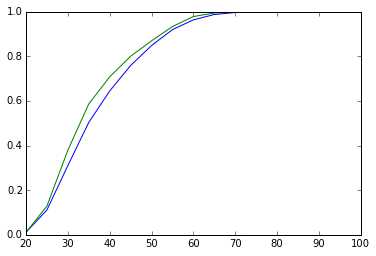

In [8]:
# Plot and find KS (for verification purposes only)
plt.plot(bins[:-1]+5,cs1/cs1.max())
plt.plot(bins[:-1]+5,cs2/cs2.max())
KS = np.nanmax(np.array(cs1/cs1.max())-np.array(cs2/cs2.max()))
print "KS", KS


csn1 = np.abs(cs1/cs1.max()) #normalize
csn2 = np.abs(cs2/cs2.max())


In [9]:
x=csn1.merge(csn2,left_index=True, right_index=True).dropna(how='any')

In [10]:
#conduct pearson correlation test
pears = scipy.stats.pearsonr(x['count_nonzero_x'],x['count_nonzero_y'])
print 'The Pearson correlation coefficient is: %f and the p-value is %f' %(pears[0],pears[1])

The Pearson correlation coefficient is: 0.996981 and the p-value is 0.000000


These distributions are strongly correlated according to Pearson's.

In [11]:
#conduct spearman
spears=scipy.stats.spearmanr(x['count_nonzero_x'],x['count_nonzero_y'])
print 'The Spearman rho is %f and the p-value is %f' %(spears[0],spears[1])

The Spearman rho is 1.000000 and the p-value is 0.000000


The distributions are correlated according to Spearman's.

In [12]:
#conduct two-sample K-S test
ks=scipy.stats.ks_2samp(x['count_nonzero_x'],x['count_nonzero_y'])
print 'The KS statistic is %f and the p-value is %f' %(ks[0],ks[1])

The KS statistic is 0.066667 and the p-value is 1.000000


The distributions are correlated according to the KS statistic.

These tests all suggest that we should fail to reject the null hypotheses that states that the age distributions are the same across genders for this month.

In [13]:
#Part 2 of HW4, assignment 1: Time of Day, Day vs. Night
citi_df['starttime'] = pd.to_datetime(citi_df['starttime'])
citi_df['dayhour'] = citi_df.starttime.apply(lambda x: x.hour)

In [14]:
#create evening and daytime split
def todr(hour): #time of day'r
    if hour >= 19 or hour <=7:
        return 'evening'
    else:
        return 'daytime'
citi_df['tod'] = citi_df.dayhour.apply(todr)

In [15]:
# Aggregates of ages, #find better code!! Alex? Code review.
ag1 = citi_df.loc[citi_df['tod'] == 'evening'].tod.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero])
ag2 = citi_df.loc[citi_df['tod'] == 'daytime'].tod.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero])
#ag1.plot(kind="bar")
#ag2.plot(kind="bar")

KS 0.0694282017946


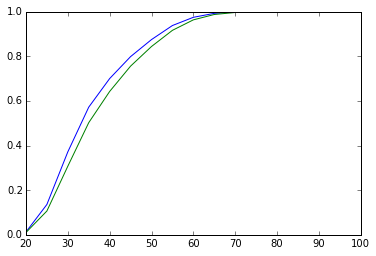

In [16]:
# Aggregates of ages, #find better code!! Alex? Code review.
cs1 = citi_df.loc[citi_df['tod'] == 'evening'].tod.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero]).cumsum()
cs2 = citi_df.loc[citi_df['tod'] == 'daytime'].tod.groupby(pd.cut(citi_df.age,bins)).agg([count_nonzero]).cumsum()
# Plot and find KS (for verification purposes only)
plt.plot(bins[:-1]+5,cs1/cs1.max())
plt.plot(bins[:-1]+5,cs2/cs2.max())
KS = np.nanmax(np.array(cs1/cs1.max())-np.array(cs2/cs2.max()))
print "KS", KS

csn1 = np.abs(cs1/cs1.max()) #normalize
csn2 = np.abs(cs2/cs2.max())


In [17]:
x=csn1.merge(csn2,left_index=True, right_index=True).dropna(how='any')


#conduct pearson correlation test
pears = scipy.stats.pearsonr(x['count_nonzero_x'],x['count_nonzero_y'])
print 'The Pearson correlation coefficient is: %f and the p-value is %f' %(pears[0],pears[1])


The Pearson correlation coefficient is: 0.997753 and the p-value is 0.000000


The distributions are correlated according to Pearson's.

In [18]:
#conduct spearman
spears=scipy.stats.spearmanr(x['count_nonzero_x'],x['count_nonzero_y'])
print 'The Spearman rho is %f and the p-value is %f' %(spears[0],spears[1])

The Spearman rho is 1.000000 and the p-value is 0.000000


The distributions are correlated according to Spearman's

In [19]:
#conduct two-sample K-S test
ks=scipy.stats.ks_2samp(x['count_nonzero_x'],x['count_nonzero_y'])
print 'The KS statistic is %f and the p-value is %f' %(ks[0],ks[1])

The KS statistic is 0.066667 and the p-value is 1.000000


In [20]:
 os.remove('2014-08 - Citi Bike trip data.csv') #git pushes can't handle it

All of these tests suggest that we should fail to reject the null hypothesis that the age distribution of riders is the same across 
different times of day.